# Updated movement model

## Data and imports

In [1]:
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm_notebook
import os, datetime

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.animation as animation

import IPython
from IPython.display import display, HTML

import sys
sys.path.append("../../models/new_baseline")

from model.model import *
from model.model_presets import BASELINE_MODEL, HIGH_MOVEMENT

In [60]:
def derive_mu_sigma_lognormal(mean, variance):
    sigma = np.sqrt(np.log(variance/(mean**2) + 1))
    mu    = np.log(mean) - .5*(sigma**2)
    return mu, sigma

NEW_BASELINE_MODEL = {
    "k" : 3,
    "timestep" : (2/24),
    "movement_dist" : lambda : np.random.lognormal(*derive_mu_sigma_lognormal(1, .001)), # high movement
    "sigma_h_arr" : np.array([19, 19, 19]),
    "sigma_v_arr" : np.array([.5, .5, .5]),
    "K_v_arr" : \
    # np.array([2250, 6620, 7280]),
    # np.array([2500, 7400, 8100]),
    np.array([2750, 8100, 8900]),
    # np.array([3000, 8800, 9700]),    
    
    
    # np.array([2700, 7900, 8600]),
    # np.array([5000, 2500, 2000]),
    # np.array([1800, 2700, 6700]),
    # np.array([600, 660, 1090]),
    # np.array([11_000, 13_000, 42_000]),
    # np.array([50_000, 6_000, 5_400]),
    # np.array([1_000, 3_000, 5_000]),
    # np.array([10_000, 20_000, 50_000]),
    "patch_densities" : np.array([.85, .08, .07]),
    "psi_v_arr" : np.array([.3, .3, .3]), # TESTING THIS AS IS
    "beta_hv_arr" : np.array([.33, .33, .33]),
    "beta_vh_arr" : np.array([.33, .33, .33]),
    "nu_v_arr" : np.array([.1, .1, .1]),
    "mu_v_arr" : np.array([1/14, 1/14, 1/14]),
    "num_households" : 2_351,
    "edge_prob" : .03,
    "num_agents" : 10_053,
    "initial_infect_proportion" : .005,
    "patch_init_infect_vector_prop_arr" : [.0, .0, .0],
    # "patch_init_infect_vector_prop_arr" : [.0555, .0286, .011],
    "nu_h_dist" : lambda : np.random.lognormal(*derive_mu_sigma_lognormal(1/5, .001)),
    "mu_h_dist" : lambda : np.random.lognormal(*derive_mu_sigma_lognormal(1/6, .001)),
    "total_time" : 200,
    "mosquito_timestep" : .005,
    "prob_adopt_itn": .0,
    "stay_home_chance": .0,
}

## Updates & validation

- Randomly assign 75.8%*89.4%≈68% of the population as forest workers who commute and work (idle) in the forest
    - Forest working agents have identical movement patterns each day—leave for work in the morning [6am] and go home (teleport) at night [6pm]
    - Non-working agents (32%) move randomly throughout the network
- There is a day/night cycle which has the following impacts:
    - Working and non-working agents awaken in the morning [6am] and go home (teleport) at night [6pm] to their home node
    - Mosquito activity (sigma_v) is heightened by 4x during 6pm–8am

In [61]:
m = BaselineModel(**NEW_BASELINE_MODEL)
data, _ = m.run(with_progress=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2400/2400 [00:53<00:00, 45.16it/s]


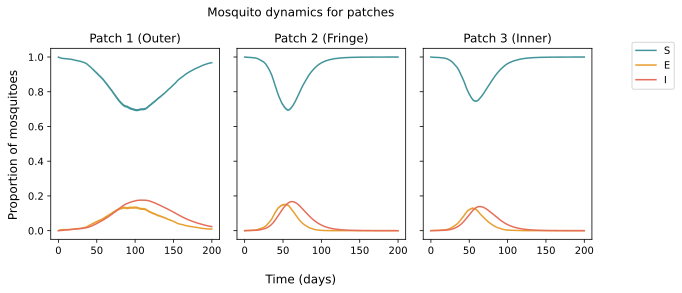

In [62]:
names = ["Patch 1 (Outer)", "Patch 2 (Fringe)", "Patch 3 (Inner)"]
labels= ["S", "E", "I"]

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(8.5,4))
cur_name = 0

for i, col in enumerate(axs):
    for j, c, l in zip(range(len(axs)), ["#41949A", "#e79f31", "#E56E5A", "#7384BB"], labels):
        if i == 0:
            axs[i].plot(np.arange(0, m.total_time, m.timestep), data["patch_sei"][i].T[j]/m.K_v_arr[i], color=c, label=l)
        else:
            axs[i].plot(np.arange(0, m.total_time, m.timestep), data["patch_sei"][i].T[j]/m.K_v_arr[i], color=c)
#     for (i, color, args) in zip(range(3), range(1,4), ["steelblue", "green", "red"], [{}, {"marker": "o", "markevery": 15}, {"linestyle": "dashed"}]):
#         sns.kdeplot(peak_infection_times[temp_names[cur_name]][patch], ax=col, bw_adjust=.5, color=color, label=f"Patch {name}" if cur_name == 0 else None, **args)

#     col.set_xlim(0,200)
    
#     col.set_xlabel("")
#     col.set_ylabel("")

    col.set_title(names[i])
    
#     cur_name += 1

fig.suptitle("Mosquito dynamics for patches")

fig.supxlabel("Time (days)")
fig.supylabel("Proportion of mosquitoes")
fig.legend(bbox_to_anchor=[1.12, 0.875])
fig.tight_layout()
plt.savefig("img/v3_3_0itn_mosq", dpi=330)

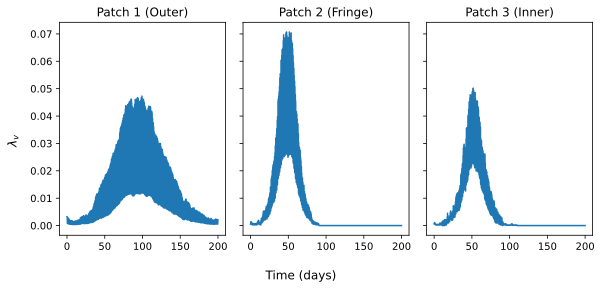

In [63]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(8.5,4))
cur_name = 0

for i, col in enumerate(axs):
    axs[i].plot(data['time'], data["lambda_v"][i])
    col.set_title(names[i])

fig.supxlabel(r"Time (days)")
fig.supylabel(r"$\lambda_v$")
fig.tight_layout()
plt.savefig("img/lambda_v_patch", dpi=330)

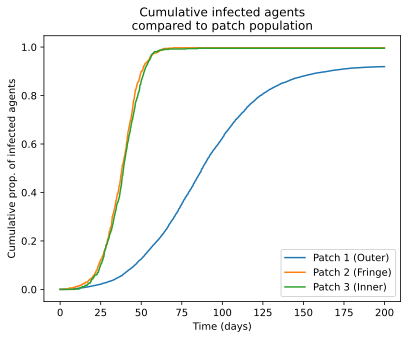

In [64]:
df = pd.DataFrame(data["infection_records"])
patch_pops = [np.sum([a.node.patch_id == j for a in m.agents]) for j in range(3)]

for i in range(3):
    vals = np.zeros(m.tick_counter)
    infs = df[df.home_patch == i].groupby(by=['time']).size().reset_index()
    vals[infs.time] = infs.iloc[:, 1]
    
    plt.plot(np.arange(0, m.total_time, m.timestep),
             vals.cumsum()/patch_pops[i],
            label=names[i])

plt.title("Cumulative infected agents\ncompared to patch population")
plt.xlabel("Time (days)")
plt.ylabel("Cumulative prop. of infected agents")
plt.legend()
plt.savefig("img/patch_infections_t", dpi=330)

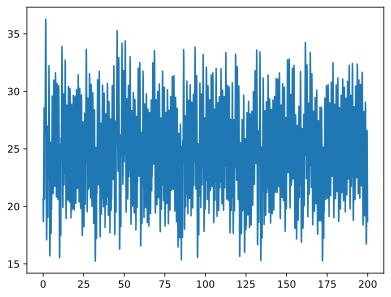

In [65]:
plt.plot(data['time'], data["temperature"])

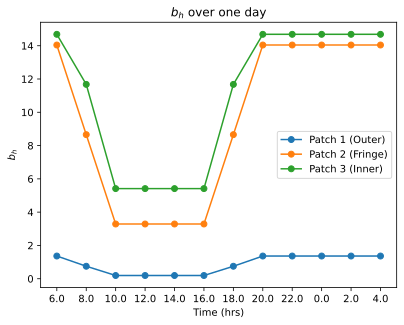

In [66]:
df = pd.DataFrame(data["patch_values"])
tick_start = 27 * 1
t = np.arange(start_time:=(tick_start*m.timestep*24 % 24), # time in simulation (hrs)
              start_time+24, # 1 day window
              step=24*m.timestep)

for i in range(3):
    plt.plot(t,
             df[df.patch_id == i].b_h.reset_index(drop=True)[tick_start:tick_start+int(1/m.timestep)],
            'o-',
            label=names[i]) #TODO: plot actual time, compare patches.
plt.xticks(t, labels=t % 24)

plt.title(r"$b_h$ over one day")
plt.xlabel("Time (hrs)")
plt.ylabel(r"$b_h$")
plt.legend()
plt.savefig("img/b_h_patch", dpi=330)

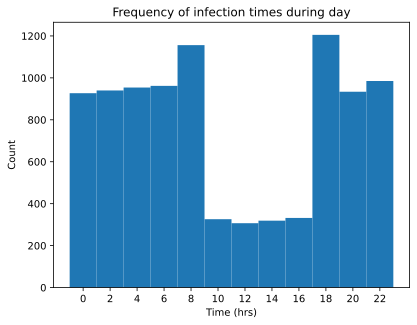

In [67]:
df = pd.DataFrame(data["infection_records"])

# plt.hist((df.time * m.timestep * 24) % 24, bins=12)
plt.bar(np.arange(0,24,2), np.unique(((df.time * m.timestep * 24) % 24).map(np.round), return_counts=True)[1], width=2)
plt.xticks(np.arange(0,24,2))
plt.title("Frequency of infection times during day")
plt.xlabel("Time (hrs)")
plt.ylabel("Count")

plt.savefig("img/infection_times", dpi=330)

In [68]:
# df = pd.DataFrame(data["patch_values"])

# fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(8.5,4))
# cur_name = 0

# for i, col in enumerate(axs):
#     if i == 0:
#         col.plot(data['time'], df[df.patch_id == i].b_v, color='red', label=r"$b_v$")
#         col.plot(data['time'], df[df.patch_id == i].b_h, color='blue', label=r"$b_h$")
#     else:
#         col.plot(data['time'], df[df.patch_id == i].b_v, color='red')
#         col.plot(data['time'], df[df.patch_id == i].b_h, color='blue')
    
#     col.set_title(names[i])

# fig.supxlabel(r"Time (days)")
# fig.supylabel(r"Biting rates")
# fig.legend(bbox_to_anchor=[1.12, 0.875])
# fig.tight_layout()
# plt.savefig("img/b_patch", dpi=330)

In [69]:
data['total_infected']/m.num_agents

0.9339500646573162

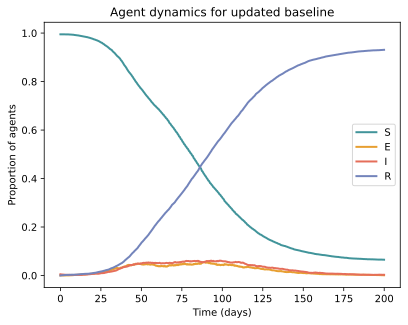

In [70]:
for j, c in zip(range(4), ["#41949A", "#e79f31", "#E56E5A", "#7384BB"]):
    plt.plot(np.arange(0, m.total_time, m.timestep), np.sum(data["agent_disease_counts"],axis=0)[j]/m.num_agents, color=c, lw=2, label=(labels+["R"])[j])
plt.xlabel("Time (days)")
plt.ylabel("Proportion of agents")
plt.title("Agent dynamics for updated baseline")
plt.legend()
# plt.xlim(85,100)
plt.savefig("img/v3_3_0itn_agent",dpi=330)

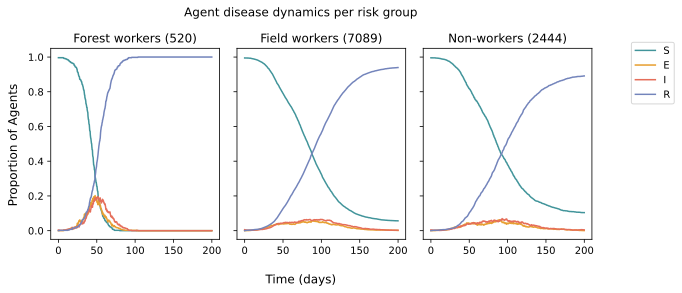

In [71]:
amts = (np.sum([a.forest_worker for a in m.agents]),
        np.sum([a.field_worker for a in m.agents]),
        np.sum([not (a.forest_worker or a.field_worker) for a in m.agents]))
names = ["Forest workers", "Field workers", "Non-workers"]
labels= ["S", "E", "I", "R"]

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(8.5,4))
cur_name = 0

for i, col in enumerate(axs):
    for j, c, l in zip(range(len(labels)), ["#41949A", "#e79f31", "#E56E5A", "#7384BB"], labels):
        if i == 0:
            axs[i].plot(np.arange(0, m.total_time, m.timestep), data["agent_disease_counts"][i][j]/amts[i], color=c, label=l)
        else:
            axs[i].plot(np.arange(0, m.total_time, m.timestep), data["agent_disease_counts"][i][j]/amts[i], color=c)
    col.set_title(names[i] + f" ({amts[i]})")
    
fig.suptitle("Agent disease dynamics per risk group")

fig.supxlabel("Time (days)")
fig.supylabel("Proportion of Agents")
fig.legend(bbox_to_anchor=[1.12, 0.875])
fig.tight_layout()
plt.savefig("img/v3_3_0itn_agent_risk_groups", dpi=330)

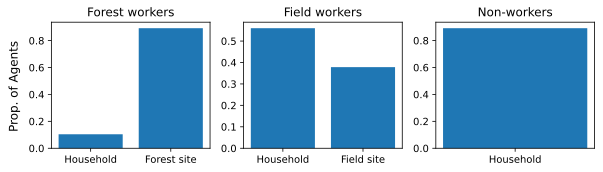

In [72]:
df = pd.DataFrame(data["infection_records"])
inf_loc_counts = df.groupby(by=["worker_type", "activity_id"]).size().reset_index(name="num")

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=False, figsize=(8.5,2.5))

for col, i in zip(axs, range(3)):
    sub_df = inf_loc_counts[inf_loc_counts.worker_type == i]
    # print(np.array(["Household", "Forest site", "Field site"])[sub_df.activity_id], sub_df.count)
    col.bar(np.array(["Household", "Forest site", "Field site"])[sub_df.activity_id], sub_df.num/amts[i])
    
    col.set_title(names[i])

# fig.suptitle("Agent infection locations by risk group")

# fig.supxlabel("Location of infection")
fig.supylabel("Prop. of Agents")
fig.tight_layout()
plt.savefig("img/agent_inf_locations", dpi=330)

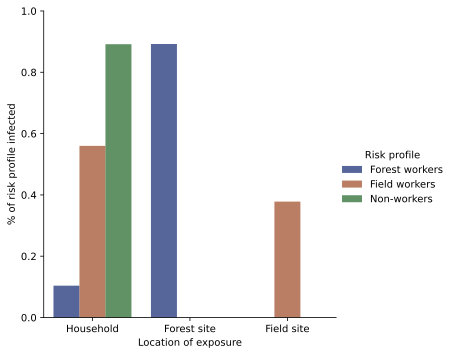

In [76]:
df = pd.DataFrame(data["infection_records"]).groupby(by=["worker_type", "activity_id"]).size().reset_index(name="num")
df["num"] = df.num.map(float)

for i, _ in df.iterrows():
    df.iloc[i, 2] /= amts[(df.iloc[i,0])]

df["worker_type"] = df.worker_type.map({0: "Forest workers", 1: "Field workers", 2: "Non-workers"})
df["activity_id"] = df.activity_id.map({0: "Household", 1: "Forest site", 2: "Field site"})

g = sns.catplot(
    data=df,
    kind="bar",
    x="activity_id",
    y="num",
    hue="worker_type",
    # errorbar="sd",
    palette="dark",
    alpha=.7,
)
# g.despine(left=True)
g.set_axis_labels("Location of exposure", "% of risk profile infected")
g.legend.set_title("Risk profile")
g.set(ylim=(0, 1))
plt.show()

## Multiple model runs

In [56]:
num_runs = 10
data = [None] * num_runs

for i in tqdm_notebook(range(num_runs)):
    m = BaselineModel(**NEW_BASELINE_MODEL)
    res, _ = m.run()

    data[i] = res
    data[i]["amts"] = (np.sum([a.forest_worker for a in m.agents]),
                    np.sum([a.field_worker for a in m.agents]),
                    np.sum([not (a.forest_worker or a.field_worker) for a in m.agents]))

  0%|          | 0/10 [00:00<?, ?it/s]

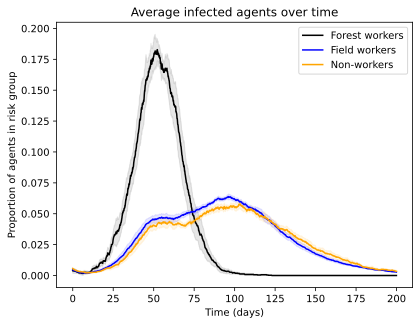

In [57]:
names = ["Forest workers", "Field workers", "Non-workers"]
palette = ["black", "blue", "orange", "green"]

for j, name, c in zip(range(num_runs), names, palette):
    avgs = np.mean([data[i]["agent_disease_counts"][j][2]/data[i]['amts'][j] for i in range(num_runs)],axis=0)
    plt.plot(data[0]["time"],
             avgs,
             color=c,
            label=name)
    ci = 1.96 * np.std([data[i]["agent_disease_counts"][j][2]/data[i]['amts'][j] for i in range(num_runs)],axis=0)/np.sqrt(num_runs)
    plt.gca().fill_between(data[0]["time"],
                           np.maximum(avgs-ci, 0),
                           (avgs+ci),
                           color=c,
                           alpha=.1)
plt.title("Average infected agents over time")
plt.xlabel("Time (days)")
plt.ylabel("Proportion of agents in risk group")
plt.legend()
plt.savefig("img/avg_infect_agent", dpi=330)

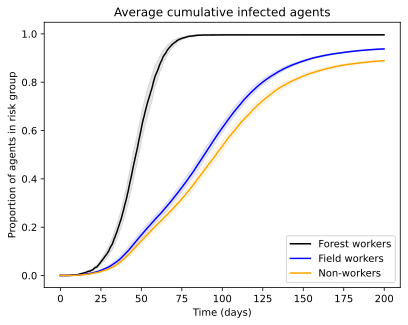

In [58]:
palette = ["black", "blue", "orange", "green"]

for j, name, c in zip(range(num_runs), names, palette):
    sums = np.cumsum([data[i]["agent_infected_unique"][j]/data[i]['amts'][j] for i in range(num_runs)],axis=1)
    avgs = np.mean(sums,axis=0)
    plt.plot(data[0]["time"],
             avgs,
             color=c,
            label=name)
    ci = 1.96 * np.std(sums,axis=0)/np.sqrt(num_runs)
    plt.gca().fill_between(data[0]["time"],
                           np.maximum(avgs-ci, 0),
                           (avgs+ci),
                           color=c,
                           alpha=.1)
plt.title("Average cumulative infected agents")
plt.xlabel("Time (days)")
plt.ylabel("Proportion of agents in risk group")
plt.legend()
plt.savefig("img/avg_cum_infect_agent", dpi=330)

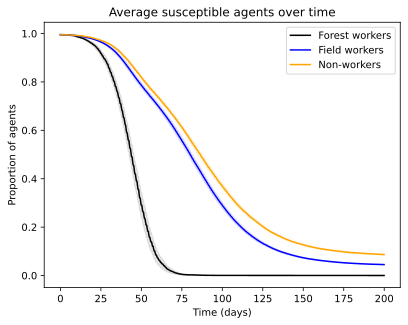

In [198]:
palette = ["black", "blue", "orange", "green"]

for j, name, c in zip(range(num_runs), names, palette):
    avgs = np.mean([data[i]["agent_disease_counts"][j][0]/data[i]['amts'][j] for i in range(num_runs)],axis=0)
    plt.plot(data[0]["time"],
             avgs,
             color=c,
            label=name)
    ci = 1.96 * np.std([data[i]["agent_disease_counts"][j][0]/data[i]['amts'][j] for i in range(num_runs)],axis=0)/np.sqrt(num_runs)
    plt.gca().fill_between(data[0]["time"],
                           np.maximum(avgs-ci, 0),
                           (avgs+ci),
                           color=c,
                           alpha=.1)
plt.title("Average susceptible agents over time")
plt.xlabel("Time (days)")
plt.ylabel("Proportion of agents")
plt.legend()
plt.show()

In [199]:
data[0].keys()

dict_keys(['time', 'lambda_hj', 'lambda_v', 'num_infected', 'agent_disease_counts', 'agent_infected_unique', 'patch_values', 'infection_records', 'time_in_household', 'time_in_field', 'temperature', 'num_movements', 'total_exposed', 'total_infected', 'total_recovered', 'total_time_in_state', 'patch_sei', 'node_seir', 'amts'])

In [200]:
import pickle as pkl

In [201]:
with open("run_+20pc.pkl", 'wb') as f:
    pkl.dump([data[i]["total_infected"] for i in range(num_runs)], f, protocol=pkl.HIGHEST_PROTOCOL)

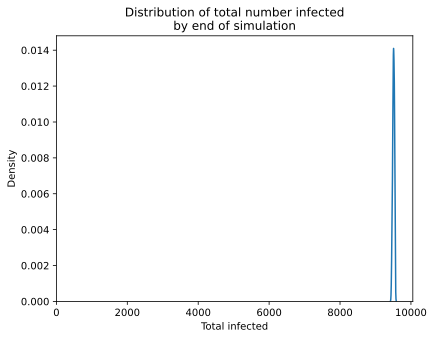

In [202]:
sns.kdeplot([data[i]["total_infected"] for i in range(num_runs)], bw_adjust=1)

plt.xlim(0, m.num_agents)
plt.xlabel("Total infected")
plt.title("Distribution of total number infected\nby end of simulation")
plt.show()

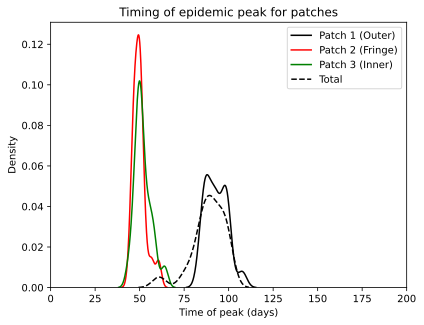

In [203]:
patch_names = ["Patch 1 (Outer)", "Patch 2 (Fringe)", "Patch 3 (Inner)"]
peak_infection_times = {patch: [np.argmax(data[i]["num_infected"][patch])*m.timestep for i in range(len(data))] for patch in range(3)}
bw_adjust_amt = .75

for patch_id in range(3):
    sns.kdeplot(peak_infection_times[patch_id],
                bw_adjust=bw_adjust_amt,
                color=['black', 'red', 'green'][patch_id],
                label=patch_names[patch_id])

peak_avgs = [np.sum(list(data[i]["num_infected"].values()),axis=0) for i in range(num_runs)]
peak_avg_times = [np.argmax(peak_avgs[i])*m.timestep for i in range(num_runs)]
sns.kdeplot(
    peak_avg_times,
    bw_adjust=bw_adjust_amt,
    color='black',
    ls='dashed',
    label='Total'
)

plt.xlim(0,m.total_time)

plt.title("Timing of epidemic peak for patches")
plt.xlabel("Time of peak (days)")
plt.ylabel("Density")
plt.legend()
plt.show()

In [8]:
data.keys()

dict_keys(['go_home', 'time', 'patch_ticks', 'lambda_hj', 'lambda_v', 'num_infected', 'agent_disease_counts', 'num_movements', 'total_exposed', 'total_infected', 'total_recovered', 'total_time_in_state', 'patch_sei', 'node_seir'])

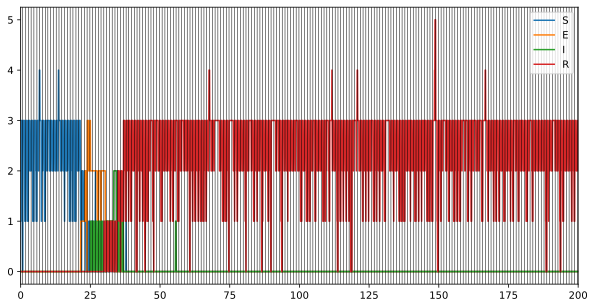

In [7]:
node_id = 823
plt.figure(figsize=(10, 5))
plt.xlim(0, 200)
         # 500)
         # len(data["time"]))

plt.plot(data["time"], [data["node_seir"][node_id][i][0] for i in range(len(data["time"]))], label="S")
plt.plot(data["time"], [data["node_seir"][node_id][i][1] for i in range(len(data["time"]))], label="E")
plt.plot(data["time"], [data["node_seir"][node_id][i][2] for i in range(len(data["time"]))], label="I")
plt.plot(data["time"], [data["node_seir"][node_id][i][3] for i in range(len(data["time"]))], label="R")
for x in data["go_home"]:
    plt.axvline(x, lw=.5, color="black")
    # plt.axvline(x*18, lw=.5, color="black", linestyle="dashed")
plt.legend()
plt.show()

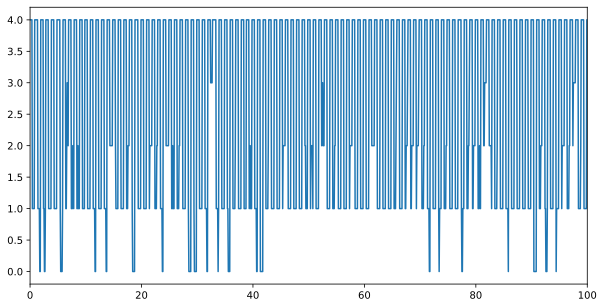

In [8]:
node_id = 34
plt.figure(figsize=(10, 5))
plt.xlim(0,100)

plt.plot(data["time"], np.sum([data["node_seir"][node_id][i] for i in range(len(data["time"]))],axis=1))
# for x in range(200):
#     plt.axvline(x*6, lw=.5, color="black", linestyle="dashed")
    # plt.axvline(x*18, lw=.5, color="black", linestyle="dashed")
plt.show()

## Experiment (preventive measure)

- Introduce an insecticide-treated net (ITN) that agents can use when sleeping. These:
    - Reduce $\sigma_h$ for each patch by a factor of $\varepsilon$

## Sens Anal

In [7]:
from copy import deepcopy
import numpy as np
import pandas as pd
import seaborn as sns

### Experiments

Varying carrying capacities:

Constant K_v of 3,000

In [8]:
def kv_const3000():
    res = deepcopy(NEW_BASELINE_MODEL)
    res["K_v_arr"] = np.array([3000, 3000, 3000])
    return BaselineModel(**res)

Constant K_v of 30,000

In [9]:
def kv_const10_000():
    res = deepcopy(NEW_BASELINE_MODEL)
    res["K_v_arr"] = np.array([30_000, 30_000, 30_000])
    return BaselineModel(**res)

Varied K_v of 1000, 3000, 5000

In [10]:
def kv_varied_1000():
    res = deepcopy(NEW_BASELINE_MODEL)
    res["K_v_arr"] = np.array([1000, 3000, 5000])
    return BaselineModel(**res)

Varied K_v of 10,000, 30,000, 50,000

In [11]:
def kv_varied_10_000():
    res = deepcopy(NEW_BASELINE_MODEL)
    res["K_v_arr"] = np.array([10_000, 30_000, 50_000])
    return BaselineModel(**res)

### Running models

In [12]:
NAMES = ["Constant (1e3)", "Constant (1e4)", "Varied (1e3)", "Varied (1e4)"]

In [15]:
def run_models(num_runs=10,
               generators=[kv_const3000, kv_const10_000, kv_varied_1000, kv_varied_10_000],
               names=NAMES):
    """Run the different models repeatedly."""
    assert len(generators) == len(names)
    
    data = {name: None for name in names}

    for (name, model_generator) in zip(names, generators):
        print(f"Running {name} model...")
        data[name] = [None] * num_runs
        
        for i in tqdm_notebook(range(num_runs)):
            m = model_generator()
            res, _ = m.run()

            data[name][i] = res

    return data

In [16]:
data = run_models(num_runs=5)

Running Constant (1e3) model...


  0%|          | 0/5 [00:00<?, ?it/s]

Running Constant (1e4) model...


  0%|          | 0/5 [00:00<?, ?it/s]

Running Varied (1e3) model...


  0%|          | 0/5 [00:00<?, ?it/s]

Running Varied (1e4) model...


  0%|          | 0/5 [00:00<?, ?it/s]

### Deriving model statistics

In [17]:
cur_names = NAMES

infection_counts = {name: [data[name][i]["total_infected"] for i in range(len(data[name]))] for name in cur_names}

peak_infection_times = {name: {patch: [np.argmax(data[name][i]["num_infected"][patch])/4 for i in range(len(data[name]))] for patch in range(3)} for name in cur_names}

num_infectious_peak  = {name: {patch: [np.max(data[name][i]["num_infected"][patch]) for i in range(len(data[name]))] for patch in range(3)} for name in cur_names}

# epidemic_peak_times  = {name: [np.argmax(np.sum(list(data[name][0]["num_infected"].values()), axis=0))] for name in NAMES}

### Results

#### Figure 3. Total average infected

In [18]:
sns.set_theme(style="whitegrid")

In [19]:
palette = ["black", "blue", "orange", "green"]

<Figure size 1000x500 with 0 Axes>

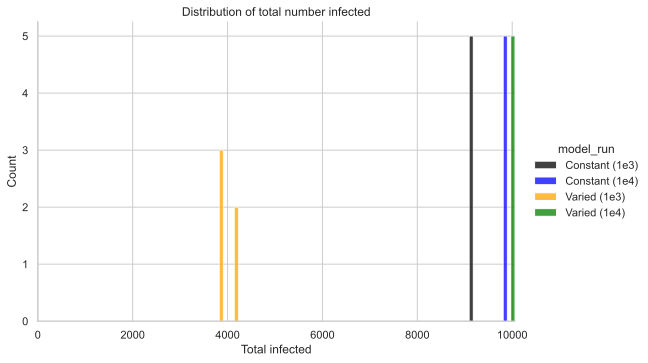

In [20]:
plt.figure(figsize=(10,5))

df = pd.DataFrame({"total_infected": [i for row in infection_counts.values() for i in row],
                   "model_run" : [name for name, row in infection_counts.items() for _ in range(len(row))]})
sns.displot(df,
            x="total_infected",
            hue="model_run",
            # kind="kde",
            # kde=True,
            # bw_adjust=.5,
            bins=20,
            fill=True,
            multiple="dodge",
            palette=palette,
            height=5,
            aspect=1.5)

# sns.histplot(df,
#             x="total_infected",
#             hue="model_run",
#             stat="density",
#             palette=["black", "mistyrose", "salmon", "crimson", "firebrick"],
#             legend=True,
#             bins=15,
#             element="step",)

# for (name, color) in zip(cur_names, ["black", "mistyrose", "salmon", "crimson", "firebrick"]):
    # sns.kdeplot(infection_counts[name], bw_adjust=.55, color=color, label=name)
    # plt.hist(infection_counts[name], color=color, label=name, alpha=.5, density=True)


plt.xlim(0, 10053)
plt.xlabel("Total infected")
plt.title("Distribution of total number infected")
# plt.legend()
plt.show()

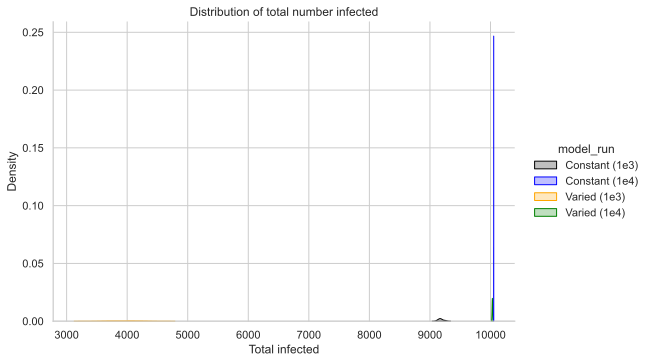

In [21]:
# plt.figure(figsize=(10,5))

df = pd.DataFrame({"total_infected": [i for row in infection_counts.values() for i in row],
                   "model_run" : [name for name, row in infection_counts.items() for _ in range(len(row))]})

sns.displot(
            # df[df.model_run == "Baseline"],
            df,
            x="total_infected",
            hue="model_run",
            kind="kde",
            # kde=True,
            # bw_adjust=.5,
            # bins=20,
            fill=True,
            # multiple="dodge",
            palette=palette,
            height=5,
            aspect=1.5)

# for name, c in zip(cur_names, palette):
#     counts, bins = np.histogram(df[df.model_run == name].total_infected, density=True, bins=5)
#     centers = (bins[:-1] + bins[1:]) / 2
    
#     plt.scatter(x=centers, y=counts/5, color=c, s=20, marker='s')


# plt.xlim(0, 1500)
plt.xlabel("Total infected")
plt.title("Distribution of total number infected")
# plt.legend()
plt.show()

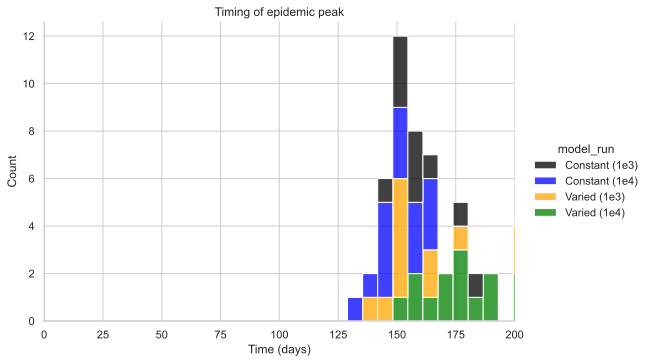

In [22]:
# plt.figure(figsize=(10,5))

df = pd.DataFrame({"peak_infection_times": [i for b in peak_infection_times.keys() for row in peak_infection_times[b].values() for i in row],
                   "model_run" : [b for b in peak_infection_times.keys() for row in peak_infection_times[b].values() for _ in range(len(row))]})
sns.displot(df,
            x="peak_infection_times",
            hue="model_run",
            # kind="kde",
            # kde=True,
            bins=30,
            fill=True,
            multiple="stack",
            palette=palette,
            height=5,
            aspect=1.5)

# for (name, color) in zip(cur_names, ["black", "mistyrose", "salmon", "crimson", "firebrick"]):
    # sns.kdeplot(infection_counts[name], bw_adjust=.55, color=color, label=name)
    # plt.hist(infection_counts[name], color=color, label=name, alpha=.5, density=True)


plt.xlim(0, 200)
plt.xlabel("Time (days)")
plt.title("Timing of epidemic peak")
# plt.legend()
plt.show()

In [23]:
cur_names = NAMES

infection_counts = {name: [data[name][i]["total_infected"] for i in range(len(data[name]))] for name in cur_names}

peak_infection_times = {name: {patch: [np.argmax(data[name][i]["num_infected"][patch])/4 for i in range(len(data[name]))] for patch in range(3)} for name in cur_names}

num_infectious_peak  = {name: {patch: [np.max(data[name][i]["num_infected"][patch]) for i in range(len(data[name]))] for patch in range(3)} for name in cur_names}

# epidemic_peak_times  = {name: [np.argmax(np.sum(list(data[name][0]["num_infected"].values()), axis=0))] for name in NAMES}

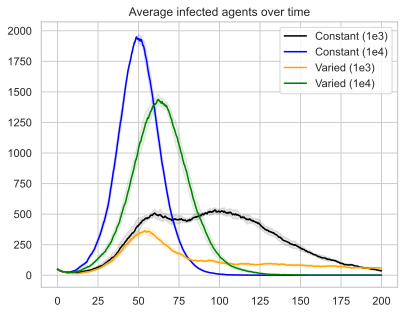

In [24]:
NUM_RUNS=5

for name, c in zip(cur_names, palette):
    avgs = np.mean([data[name][i]["agent_disease_counts"][2] for i in range(NUM_RUNS)],axis=0)
    plt.plot(data[name][0]["time"],
             avgs,
             color=c,
            label=name)
    ci = 1.96 * np.std([data[name][i]["agent_disease_counts"][2] for i in range(NUM_RUNS)],axis=0)/np.sqrt(NUM_RUNS)
    plt.gca().fill_between(data[name][0]["time"],
                           np.maximum(avgs-ci, 0),
                           avgs+ci,
                           color=c,
                           alpha=.1)
plt.title("Average infected agents over time")
plt.legend()
plt.show()

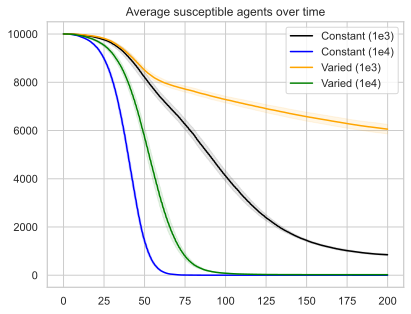

In [25]:
NUM_RUNS=5

for name, c in zip(cur_names, palette):
    avgs = np.mean([data[name][i]["agent_disease_counts"][0] for i in range(NUM_RUNS)],axis=0)
    plt.plot(data[name][0]["time"],
             avgs,
             color=c,
            label=name)
    ci = 1.96 * np.std([data[name][i]["agent_disease_counts"][0] for i in range(NUM_RUNS)],axis=0)/np.sqrt(NUM_RUNS)
    plt.gca().fill_between(data[name][0]["time"],
                           np.maximum(avgs-ci, 0),
                           avgs+ci,
                           color=c,
                           alpha=.1)
plt.title("Average susceptible agents over time")
plt.legend()
plt.show()

## Sens Anal 2 - ITNs

In [27]:
from copy import deepcopy
import numpy as np
import pandas as pd
import seaborn as sns

### Experiments

Varying carrying capacities:

0 protection

In [28]:
def itn0():
    res = deepcopy(NEW_BASELINE_MODEL)
    res["prob_adopt_itn"] = 0
    return BaselineModel(**res)

0.5

In [29]:
def itn50():
    res = deepcopy(NEW_BASELINE_MODEL)
    res["prob_adopt_itn"] = .5
    return BaselineModel(**res)

.924 (true)

In [30]:
def itn924():
    res = deepcopy(NEW_BASELINE_MODEL)
    res["prob_adopt_itn"] = .924
    return BaselineModel(**res)

100

In [31]:
def itn100():
    res = deepcopy(NEW_BASELINE_MODEL)
    res["prob_adopt_itn"] = 1.
    return BaselineModel(**res)

### Running models

In [32]:
NAMES = ["No adoption", "50%", "92.4% (actual)", "100%"]

In [33]:
def run_models(num_runs=10,
               generators=[itn0, itn50, itn924, itn100],
               names=NAMES):
    """Run the different models repeatedly."""
    assert len(generators) == len(names)
    
    data = {name: None for name in names}

    for (name, model_generator) in zip(names, generators):
        print(f"Running {name} model...")
        data[name] = [None] * num_runs
        
        for i in tqdm_notebook(range(num_runs)):
            m = model_generator()
            res, _ = m.run()

            data[name][i] = res

    return data

In [34]:
data = run_models(num_runs=5)

Running No adoption model...


  0%|          | 0/5 [00:00<?, ?it/s]

Running 50% model...


  0%|          | 0/5 [00:00<?, ?it/s]

Running 92.4% (actual) model...


  0%|          | 0/5 [00:00<?, ?it/s]

Running 100% model...


  0%|          | 0/5 [00:00<?, ?it/s]

### Deriving model statistics

In [35]:
cur_names = NAMES

infection_counts = {name: [data[name][i]["total_infected"] for i in range(len(data[name]))] for name in cur_names}

peak_infection_times = {name: {patch: [np.argmax(data[name][i]["num_infected"][patch])/4 for i in range(len(data[name]))] for patch in range(3)} for name in cur_names}

num_infectious_peak  = {name: {patch: [np.max(data[name][i]["num_infected"][patch]) for i in range(len(data[name]))] for patch in range(3)} for name in cur_names}

# epidemic_peak_times  = {name: [np.argmax(np.sum(list(data[name][0]["num_infected"].values()), axis=0))] for name in NAMES}

### Results

#### Figure 3. Total average infected

In [36]:
sns.set_theme(style="whitegrid")

In [37]:
palette = ["black", "salmon", "crimson", "firebrick"]

Exception ignored in: <function tqdm.__del__ at 0x150366020>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mcs/lib/python3.11/site-packages/tqdm/std.py", line 1147, in __del__
    def __del__(self):

KeyboardInterrupt: 


<Figure size 1000x500 with 0 Axes>

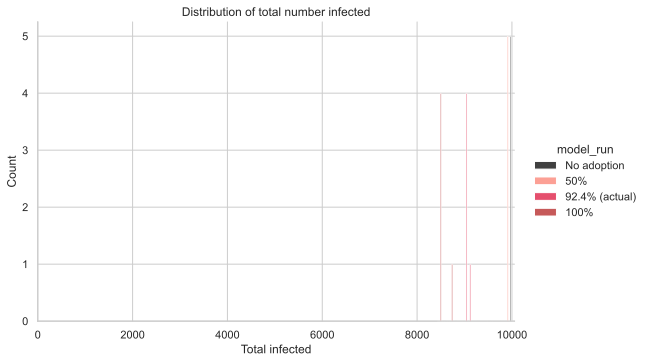

In [38]:
plt.figure(figsize=(10,5))

df = pd.DataFrame({"total_infected": [i for row in infection_counts.values() for i in row],
                   "model_run" : [name for name, row in infection_counts.items() for _ in range(len(row))]})
sns.displot(df,
            x="total_infected",
            hue="model_run",
            # kind="kde",
            # kde=True,
            # bw_adjust=.5,
            bins=20,
            fill=True,
            multiple="dodge",
            palette=palette,
            height=5,
            aspect=1.5)

# sns.histplot(df,
#             x="total_infected",
#             hue="model_run",
#             stat="density",
#             palette=["black", "mistyrose", "salmon", "crimson", "firebrick"],
#             legend=True,
#             bins=15,
#             element="step",)

# for (name, color) in zip(cur_names, ["black", "mistyrose", "salmon", "crimson", "firebrick"]):
    # sns.kdeplot(infection_counts[name], bw_adjust=.55, color=color, label=name)
    # plt.hist(infection_counts[name], color=color, label=name, alpha=.5, density=True)


plt.xlim(0, 10053)
plt.xlabel("Total infected")
plt.title("Distribution of total number infected")
# plt.legend()
plt.show()

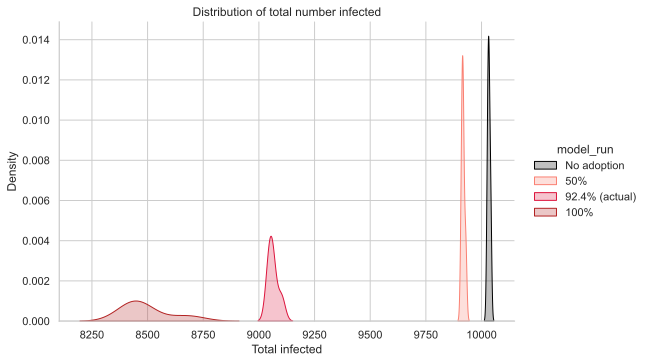

In [40]:
# plt.figure(figsize=(10,5))

df = pd.DataFrame({"total_infected": [i for row in infection_counts.values() for i in row],
                   "model_run" : [name for name, row in infection_counts.items() for _ in range(len(row))]})

sns.displot(
            # df[df.model_run == "Baseline"],
            df,
            x="total_infected",
            hue="model_run",
            kind="kde",
            # kde=True,
            # bw_adjust=.5,
            # bins=20,
            fill=True,
            # multiple="dodge",
            palette=palette,
            height=5,
            aspect=1.5)

# for name, c in zip(cur_names, palette):
#     counts, bins = np.histogram(df[df.model_run == name].total_infected, density=True, bins=5)
#     centers = (bins[:-1] + bins[1:]) / 2
    
#     plt.scatter(x=centers, y=counts/5, color=c, s=20, marker='s')


# plt.xlim(0, 1500)
plt.xlabel("Total infected")
plt.title("Distribution of total number infected")
# plt.legend()
plt.show()

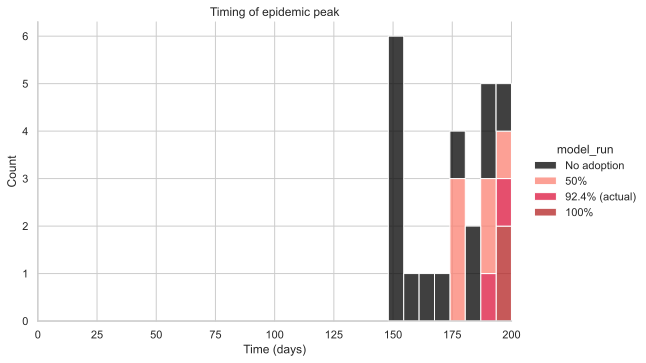

In [41]:
# plt.figure(figsize=(10,5))

df = pd.DataFrame({"peak_infection_times": [i for b in peak_infection_times.keys() for row in peak_infection_times[b].values() for i in row],
                   "model_run" : [b for b in peak_infection_times.keys() for row in peak_infection_times[b].values() for _ in range(len(row))]})
sns.displot(df,
            x="peak_infection_times",
            hue="model_run",
            # kind="kde",
            # kde=True,
            bins=30,
            fill=True,
            multiple="stack",
            palette=palette,
            height=5,
            aspect=1.5)

# for (name, color) in zip(cur_names, ["black", "mistyrose", "salmon", "crimson", "firebrick"]):
    # sns.kdeplot(infection_counts[name], bw_adjust=.55, color=color, label=name)
    # plt.hist(infection_counts[name], color=color, label=name, alpha=.5, density=True)


plt.xlim(0, 200)
plt.xlabel("Time (days)")
plt.title("Timing of epidemic peak")
# plt.legend()
plt.show()

In [42]:
cur_names = NAMES

infection_counts = {name: [data[name][i]["total_infected"] for i in range(len(data[name]))] for name in cur_names}

peak_infection_times = {name: {patch: [np.argmax(data[name][i]["num_infected"][patch])/4 for i in range(len(data[name]))] for patch in range(3)} for name in cur_names}

num_infectious_peak  = {name: {patch: [np.max(data[name][i]["num_infected"][patch]) for i in range(len(data[name]))] for patch in range(3)} for name in cur_names}

# epidemic_peak_times  = {name: [np.argmax(np.sum(list(data[name][0]["num_infected"].values()), axis=0))] for name in NAMES}

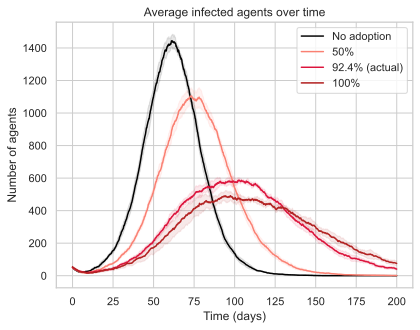

In [43]:
NUM_RUNS=5

for name, c in zip(cur_names, palette):
    avgs = np.mean([data[name][i]["agent_disease_counts"][2] for i in range(NUM_RUNS)],axis=0)
    plt.plot(data[name][0]["time"],
             avgs,
             color=c,
            label=name)
    ci = 1.96 * np.std([data[name][i]["agent_disease_counts"][2] for i in range(NUM_RUNS)],axis=0)/np.sqrt(NUM_RUNS)
    plt.gca().fill_between(data[name][0]["time"],
                           np.maximum(avgs-ci, 0),
                           avgs+ci,
                           color=c,
                           alpha=.1)
plt.title("Average infected agents over time")
plt.xlabel("Time (days)")
plt.ylabel("Number of agents")
plt.legend()
plt.show()

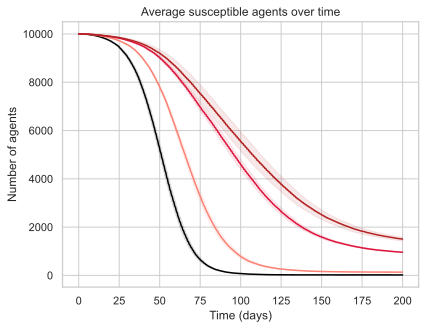

In [44]:
NUM_RUNS=5

for name, c in zip(cur_names, palette):
    avgs = np.mean([data[name][i]["agent_disease_counts"][0] for i in range(NUM_RUNS)],axis=0)
    plt.plot(data[name][0]["time"],
             avgs,
             color=c,
            label=name)
    ci = 1.96 * np.std([data[name][i]["agent_disease_counts"][0] for i in range(NUM_RUNS)],axis=0)/np.sqrt(NUM_RUNS)
    plt.gca().fill_between(data[name][0]["time"],
                           np.maximum(avgs-ci, 0),
                           avgs+ci,
                           color=c,
                           alpha=.1)
plt.title("Average susceptible agents over time")
plt.xlabel("Time (days)")
plt.ylabel("Number of agents")
# plt.legend()
plt.show()